In [1]:
#%reset

In [2]:
import pandas as pd
%pylab inline
import seaborn as sns
sns.set(style="darkgrid")

Populating the interactive namespace from numpy and matplotlib


# Load data

In [3]:
customers_data_ini = pd.read_csv(
    'customers_data.csv', decimal=',', index_col=0)

customers_data = customers_data_ini[
    [col for col in customers_data_ini.columns
     if col not in ['price',
                    'product_width_cm',
                    'product_weight_g',
                    'order_purchase_timestamp']]]

# Define intervals number
intervals_n = 6
# Define clusters number
clusters_n = 7

## Decompose columns in groups

In [4]:
small_int_columns = ['review_score', 
                     'order_week_day',
                     'moment_of_day', ]

value_columns = ['order_item_id', 'payment_sequential', 'price', 
                 'dist_to_seller', 'comment_propensity', 
                 'payment_installments', 'payment_value', 
                 'product_weight_g',  'product_length_cm', 
                 'product_height_cm', 'product_width_cm',
                 'product_name_lenght', 'product_description_lenght',
                 'product_photos_qty', 'freight_value', 
                 'delivery_delay', 'last_purchase_days', 'order_id', ]

states_columns = [
    col for col in customers_data.columns if col.startswith("state_")]
prod_cat_columns = [
    col for col in customers_data.columns if col.startswith("prod_cat_")]
paytype_columns = [
    col for col in customers_data.columns if col.startswith("pay_type_")]

cat_groups = {'states': states_columns,
              'categories': prod_cat_columns, 'payment types': paytype_columns}

# Functions

## Display functions

In [5]:
from sklearn.manifold import TSNE


class MyNumber:
    def __init__(self, val):
        self.val = val

    def __format__(self, format_spec):
        ss = ('{0:'+format_spec+'}').format(self.val)
        if ('e' in ss):
            mantissa, exp = ss.split('e')
            return mantissa + 'e' + exp[2]
        return ss


def visu_columns_repartition(_cuts, _labels, _name):
    # Get table representing proportion of labels in each cut
    cross_tab_prop = pd.crosstab(
        index=_cuts, columns=_labels, normalize="index")
    # Get dispertion mean processing first dispertion for each label
    dispertion_mean = cross_tab_prop.apply(
        lambda x: np.std(x, ddof=1) / np.mean(x) * 100, axis=0).mean()
    # Float to string
    dispertion_mean_str = "{:.2f}".format(dispertion_mean)
    # Plot cross table representing proportion of labels in each cut
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    cross_tab_prop.plot(kind='bar', stacked=True,
                        colormap='tab10', figsize=(16, 9), ax=ax)
    # Get count table to have how many values for each cut
    cross_tab = pd.crosstab(index=_cuts, columns=_labels)
    # Display count table
    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                              cross_tab.loc[x],
                                              cross_tab_prop.loc[x].cumsum()):

            plt.text(x=n - 0.17,
                     y=(y_loc - proportion) + (proportion / 2),
                     s=f'{count}\n({np.round(proportion * 100, 1)}%)',
                     color="black",
                     fontsize=12,
                     fontweight="bold")

    plt.title(_name+' dispertion: '+dispertion_mean_str, size=20)
    plt.legend(loc="upper left", ncol=2)
    plt.xlabel(_name+' dispertion', size=20)
    plt.ylabel("Proportion", size=20)
    plt.xticks(size=20)
    plt.show()


def visu_repartition(_customers_data, _labels):

    for column in _customers_data.columns:
        if column in small_int_columns:
            min_val = _customers_data[column].min()
            max_val = _customers_data[column].max()
            step = 1
            cuts_val = np.arange(min_val, max_val + step + 1, step)
            cuts = pd.cut(_customers_data[column], cuts_val, right=False)
        elif column in value_columns:
            intervals_temp = 0
            cpt = intervals_n
            while intervals_temp < intervals_n and cpt < 5e2:
                cuts = pd.qcut(_customers_data[column], cpt, duplicates='drop')
                intervals_temp = len(cuts.unique())
                cpt = cpt+1
        else:
            continue

        visu_columns_repartition(cuts, _labels, column)

    for group in cat_groups:
        is_not_in_group = [
            x not in _customers_data.columns for x in cat_groups[group]]
        if (sum(numpy.multiply(is_not_in_group, 1)) == 0):
            cuts = _customers_data[cat_groups[group]].idxmax(axis=1)
            visu_columns_repartition(cuts, _labels, group)


def visu_TSNE(_title, _dataframe, _labels_col):
    dataframe_embedded = TSNE(n_components=2).fit_transform(_dataframe)

    colors = [plt.cm.Spectral(i/float(max(np.unique(_labels_col))))
              for i in range(max(np.unique(_labels_col)+1))]

    df = pd.DataFrame(_labels_col)
    df = df.applymap(lambda ind: colors[ind])
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    plt.scatter(dataframe_embedded[:, 1],
                dataframe_embedded[:, 0],
                c=df.values.tolist(),
                s=15)

    plt.title(_title+': TSNE with 2 composants', fontsize=20)
    plt.xlabel('Feature_1', fontsize=20)
    plt.ylabel('Feature_2', fontsize=20)
    plt.show()

In [6]:
def radarplot(_repartition_df, _title):
    # Copy repartition dataframe
    repartition_df = _repartition_df.copy()

    # Get repartition dataframe index
    labels_ = repartition_df.index.to_list()
    # Copy first repartition element and put it at the end of repartition list
    labels_.append(labels_[0])

    # Copy repartition dataframe first row at the end of repartition dataframe
    repartition_df.loc[repartition_df.index[0]+'_'] = \
        repartition_df.loc[repartition_df.index[0]]

    # Create axis from 0 to 2*PI
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(repartition_df))

    plt.figure(figsize=(12, 12))
    plt.subplot(polar=True)
    for method in repartition_df.columns:
        # Plot method repartition curve
        plt.plot(label_loc, repartition_df[method], label=method, linewidth=6)

    plt.title('Variables dispersion  '+_title, size=20)
    # Transform linear plot to polar plot
    lines, labels = plt.thetagrids(
        np.degrees(label_loc), labels=labels_, size=18)
    plt.yticks(size=15)
    plt.show()

## Dispertion function

In [7]:
def get_dispersion(_customers_data, _labels):

    dispersion = pd.DataFrame(columns=['dispersion'])
    for column in _customers_data.columns:
        if column in small_int_columns:
            min_val = _customers_data[column].min()
            max_val = _customers_data[column].max()
            step = 1
            cuts_val = np.arange(min_val, max_val + step + 1, step)
            cuts = pd.cut(_customers_data[column], cuts_val, right=False)
        elif column in value_columns:
            intervals_temp = 0
            cpt = intervals_n
            while intervals_temp < intervals_n and cpt < 5e2:
                cuts = pd.qcut(_customers_data[column], cpt, duplicates='drop')
                intervals_temp = len(cuts.unique())
                cpt = cpt+1
        else:
            continue

        cross_tab_prop = pd.crosstab(
            index=cuts, columns=_labels, normalize="index")

        dispersion.loc[column, 'dispersion'] = cross_tab_prop.apply(
            lambda x: np.std(x, ddof=1) / np.mean(x) * 100, axis=0).mean()

    for group in cat_groups:
        is_not_in_group = [
            x not in _customers_data.columns for x in cat_groups[group]]
        if (sum(numpy.multiply(is_not_in_group, 1)) == 0):
            cuts = _customers_data[cat_groups[group]].idxmax(axis=1)

            cross_tab_prop = pd.crosstab(index=cuts,
                                         columns=_labels,
                                         normalize="index")

            dispersion.loc[group, 'dispersion'] = cross_tab_prop.apply(
                lambda x: np.std(x, ddof=1) / np.mean(x) * 100, axis=0).mean()

    return dispersion

## Function to weight dataframe

In [8]:
def get_weighted_col(_customer_data, _columns, _coef):
    data = _customer_data.copy()
    data[_columns] = data[_columns]*_coef
    return data

# Evaluate columns type impact on clustering

## Global clustering

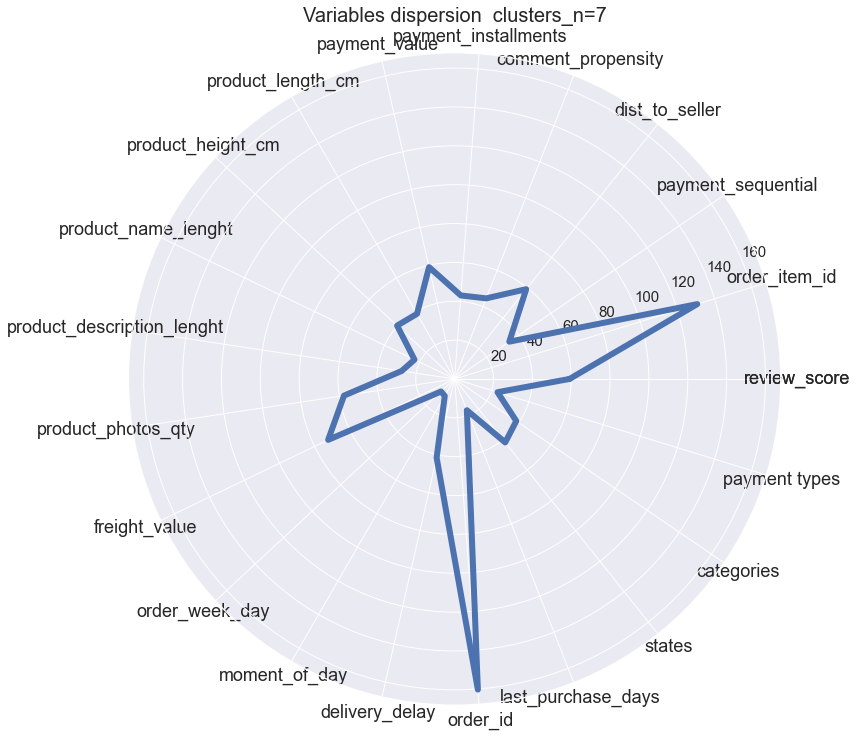

                            dispersion
order_id                    160.328225
order_item_id               130.713838
freight_value                72.231503
review_score                 59.140927
dist_to_seller               59.099414
payment_value                 59.04625
product_photos_qty           57.562536
comment_propensity           44.568023
payment_installments         43.089417
states                       41.772974
delivery_delay               41.557527
product_height_cm            40.360518
product_length_cm             38.70629
categories                   38.432469
payment_sequential           34.069482
product_description_lenght   27.562429
payment types                23.114913
product_name_lenght          22.909383
last_purchase_days           17.287154
moment_of_day                10.120703
order_week_day                9.474839


In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

# Select dataframe to process
dataframe = customers_data

# Create scaled dataframe
dataframe_scaled = preprocessing.StandardScaler().fit_transform(dataframe)
dataframe_scaled = pd.DataFrame(dataframe_scaled, columns=dataframe.columns)

# Create weighted scaled dataframe to avoid overweight categories
dataframe_weighted = dataframe_scaled
dataframe_weighted = get_weighted_col(
    dataframe_scaled, states_columns, 1/len(states_columns))
dataframe_weighted = get_weighted_col(
    dataframe_weighted, prod_cat_columns, 1/len(prod_cat_columns))
dataframe_weighted = get_weighted_col(
    dataframe_weighted, paytype_columns, 1/len(paytype_columns))

# Apply KMeans on scaled dataframe
clusterer = KMeans(n_clusters=clusters_n, random_state=0).fit(dataframe_weighted)

# Get dispertion value for each variable
global_dispersion_vals = get_dispersion(dataframe_weighted, clusterer.labels_)

# Plot dispersion on radarplot
radarplot(global_dispersion_vals, 'clusters_n='+str(clusters_n))

global_dispersion_vals = global_dispersion_vals.sort_values(
    by=['dispersion'], ascending=False)

print(global_dispersion_vals)

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_3260/605568484.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(global_dispersion_vals.index), rotation=90, size=15)


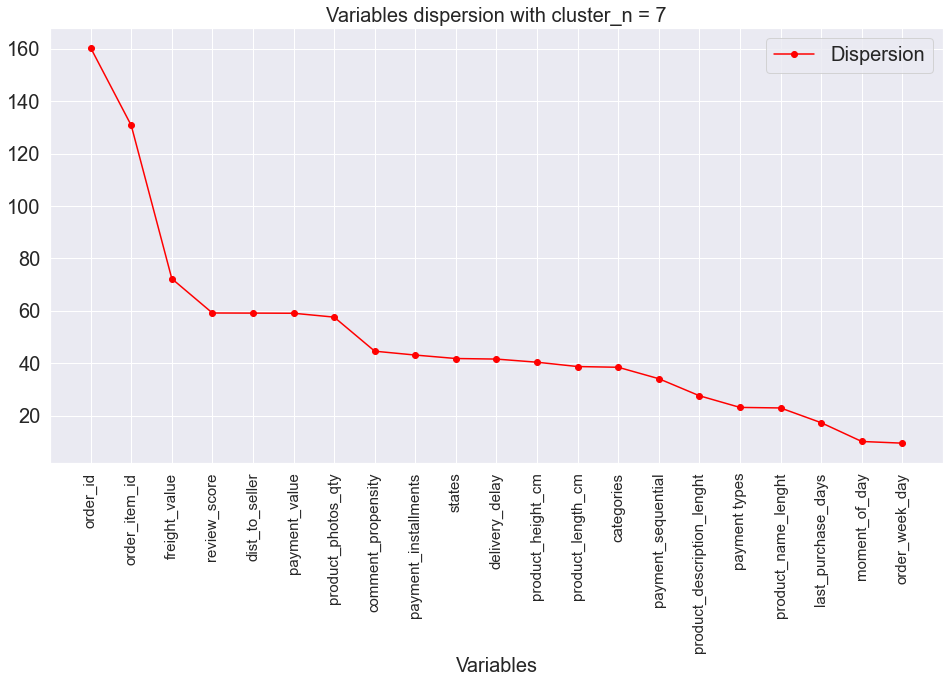

In [10]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

# First plot
ax.plot(global_dispersion_vals['dispersion'], color='red', marker='o', label='Dispersion')
plt.yticks(size=20)

# X tick label shapping
ax.set_xticklabels(list(global_dispersion_vals.index), rotation=90, size=15)
ax.set_xlabel('Variables', fontsize=20)

# Add legend
ax.legend(fontsize=20)

# Add title
plt.title('Variables dispersion with cluster_n = ' +
          str(clusters_n), fontsize=20)

plt.show()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


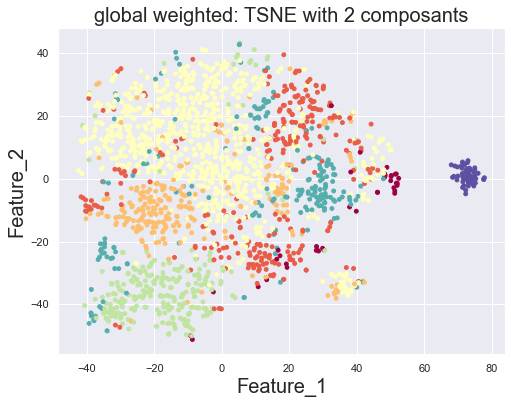

In [11]:
# Visualize clustering result on two features
visu_TSNE('global weighted',
          dataframe_weighted.loc[::50], clusterer.labels_[::50])

# Test Kmeans on variables added one by one

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

scores_disp_df = pd.DataFrame(
    columns=['score', 'dispersion', 'cluster size std'])

# Create scaled dataframe
dataframe = customers_data
dataframe_scaled = preprocessing.StandardScaler().fit_transform(dataframe)
dataframe_scaled = pd.DataFrame(
    dataframe_scaled, columns=dataframe.columns)
    
for ind in range(0, len(global_dispersion_vals)):
    print(global_dispersion_vals.index[ind])
    # At each iteration, add a new sorted variable ranged
    # from higher dispersion to lower dispersion
    high_dispersion_var = global_dispersion_vals.index[:ind+1]

    # MANAGE GROUP NAME CASE
    # Get group names if present
    high_dispersion_cat_groups = [
        column for column in high_dispersion_var
        if column in cat_groups.keys()]
    # Get high_dispersion_var without group names
    high_dispersion_var = [
        ele for ele in high_dispersion_var
        if ele not in high_dispersion_cat_groups]

    # Add categories for each group name found in high_dispersion_var
    for key in high_dispersion_cat_groups:
        high_dispersion_var = high_dispersion_var+cat_groups[key]

    # Create weighted scaled dataframe to avoid overweight categories
    dataframe_weighted = dataframe_scaled[high_dispersion_var]
    for high_disp_cat_group in high_dispersion_cat_groups:
        dataframe_weighted = get_weighted_col(
            dataframe_weighted, cat_groups[high_disp_cat_group],
            1/len(cat_groups[high_disp_cat_group]))

    # KMEANS
    # Apply KMeans on scaled dataframe
    clusterer = KMeans(n_clusters=clusters_n, random_state=0).fit(
        dataframe_weighted)

    # Save silhouette and dispersion
    dispersion_vals_tp = get_dispersion(dataframe_weighted.iloc[::20, :], clusterer.labels_[::20])
    scores_disp_df.loc[global_dispersion_vals.index[ind], 'score'] = silhouette_score(
        dataframe_weighted.iloc[::20, :], clusterer.labels_[::20])
    scores_disp_df.loc[global_dispersion_vals.index[ind], 'dispersion'] = dispersion_vals_tp.mean()[
        'dispersion']
    scores_disp_df.loc[global_dispersion_vals.index[ind], 'cluster size std'] = std(
        [sum(clusterer.labels_ == id) for id in set(clusterer.labels_)])

order_id
order_item_id
freight_value
review_score
dist_to_seller
payment_value
product_photos_qty
comment_propensity
payment_installments
states
delivery_delay
product_height_cm
product_length_cm
categories
payment_sequential
product_description_lenght
payment types
product_name_lenght
last_purchase_days
moment_of_day
order_week_day


In [13]:
scores_disp_df

,score,dispersion,cluster size std
order_id,1.0,141.421356,31986.354594
order_item_id,0.990502,175.981843,28442.330223
freight_value,0.796028,155.702072,26779.493369
review_score,0.635147,130.229321,20976.764328
dist_to_seller,0.511572,113.549354,18474.93529
payment_value,0.457427,104.016169,18154.954144
product_photos_qty,0.352889,93.087679,15385.445849
comment_propensity,0.314357,87.646882,16226.495598
payment_installments,0.263404,79.60384,13193.702717
states,0.254908,76.771096,13187.925634


/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_3260/3999354742.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(scores_disp_df.index), rotation=90, size=15)


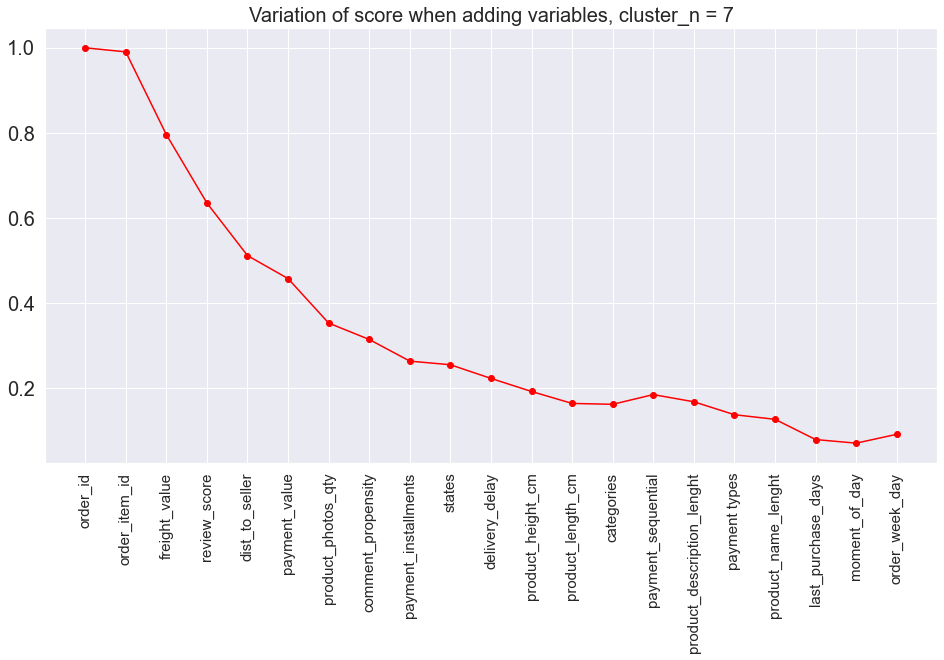

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_3260/3999354742.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(scores_disp_df.index), rotation=90, size=15)


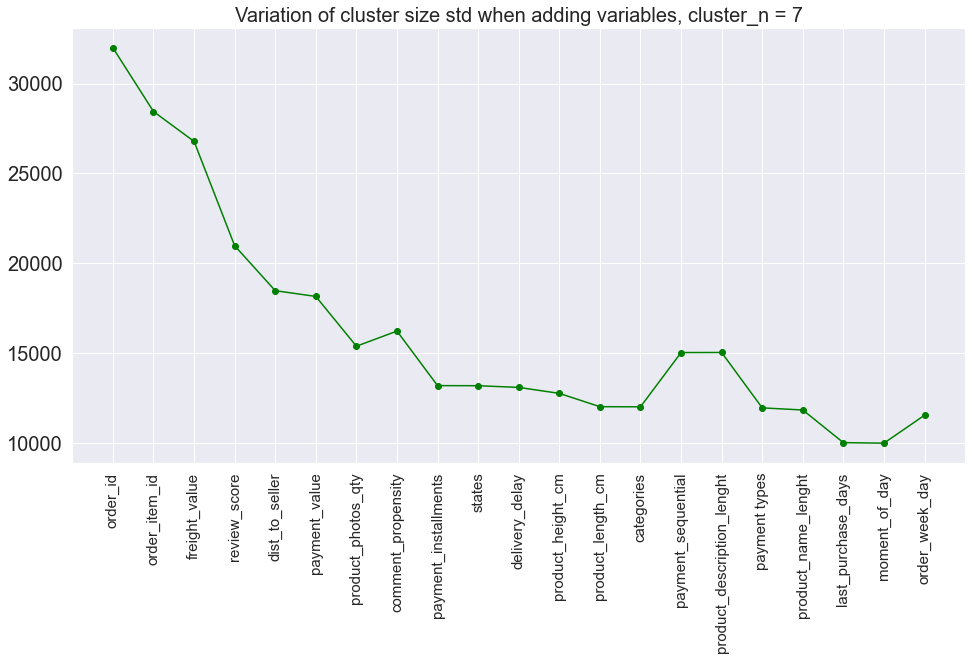

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_3260/3999354742.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(scores_disp_df.index), rotation=90, size=15)


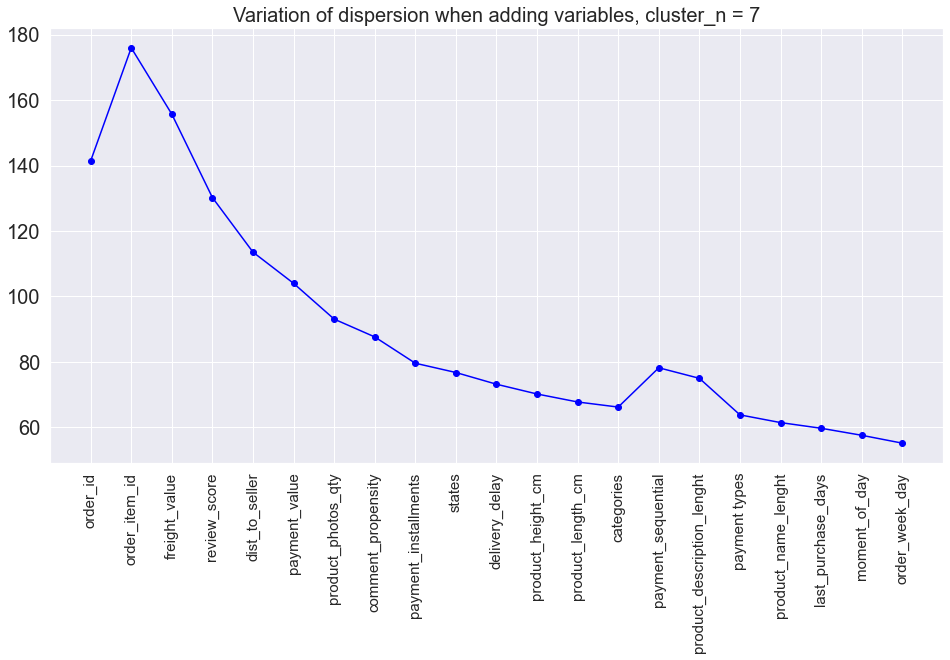

In [14]:
# create figure and axis objects with subplots()

# First plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
ax.plot(scores_disp_df.index,
        scores_disp_df['score'], color='red', marker='o', label='Score')
ax.set_xticklabels(list(scores_disp_df.index), rotation=90, size=15)
plt.yticks(size=20)
plt.title('Variation of score when adding variables, cluster_n = ' +
          str(clusters_n), fontsize=20)
plt.show()

# Second plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
ax.plot(scores_disp_df['cluster size std'], color='green', marker='o', label='Cluster size std')
ax.set_xticklabels(list(scores_disp_df.index), rotation=90, size=15)
plt.yticks(size=20)
plt.title('Variation of cluster size std when adding variables, cluster_n = ' +
          str(clusters_n), fontsize=20)
plt.show()

# Third plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
ax.plot(scores_disp_df['dispersion'], color='blue', marker='o', label='Dispersion')
ax.set_xticklabels(list(scores_disp_df.index), rotation=90, size=15)
plt.yticks(size=20)
plt.title('Variation of dispersion when adding variables, cluster_n = ' +
          str(clusters_n), fontsize=20)
plt.show()

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_3260/2046849511.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticklabels, rotation=90, size=15)


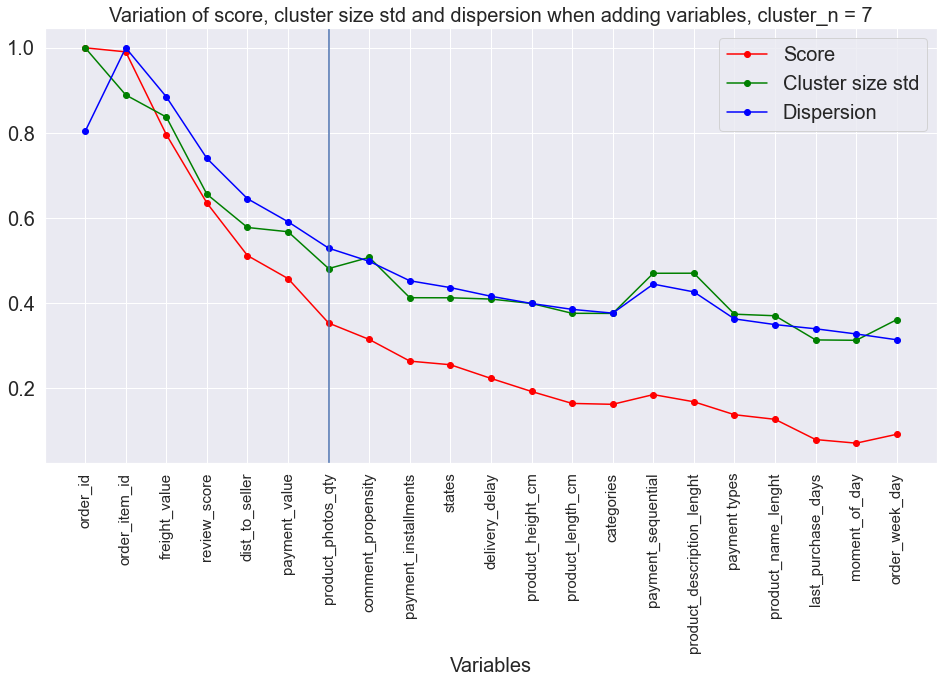

In [15]:
# create figure and axis objects with subplots()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

# First plot
ax.plot(scores_disp_df.index,
        scores_disp_df['score'], color='red', marker='o', label='Score')
plt.yticks(size=20)

# Second plot
ax.plot(scores_disp_df['cluster size std'] /
        scores_disp_df['cluster size std'].max(), color='green', marker='o', label='Cluster size std')
plt.yticks(size=20)

# Third plot
ax.plot(scores_disp_df['dispersion'] /
        scores_disp_df['dispersion'].max(), color='blue', marker='o', label='Dispersion')
plt.yticks(size=20)

# X tick label shapping
x_ticklabels = [text.replace('_mean', '')
                for text in list(scores_disp_df.index)]
ax.set_xticklabels(x_ticklabels, rotation=90, size=15)
ax.set_xlabel('Variables', fontsize=20)

# Add legend
ax.legend(fontsize=20)

# Add title
plt.title('Variation of score, cluster size std and dispersion when adding variables, cluster_n = ' +
          str(clusters_n), fontsize=20)

plt.axvline(7, 0, 1e6, label='optimal clusters number')

plt.show()

## Kmeans on selected variables

['order_id', 'order_item_id', 'freight_value', 'review_score', 'dist_to_seller', 'payment_value', 'product_photos_qty', 'comment_propensity']


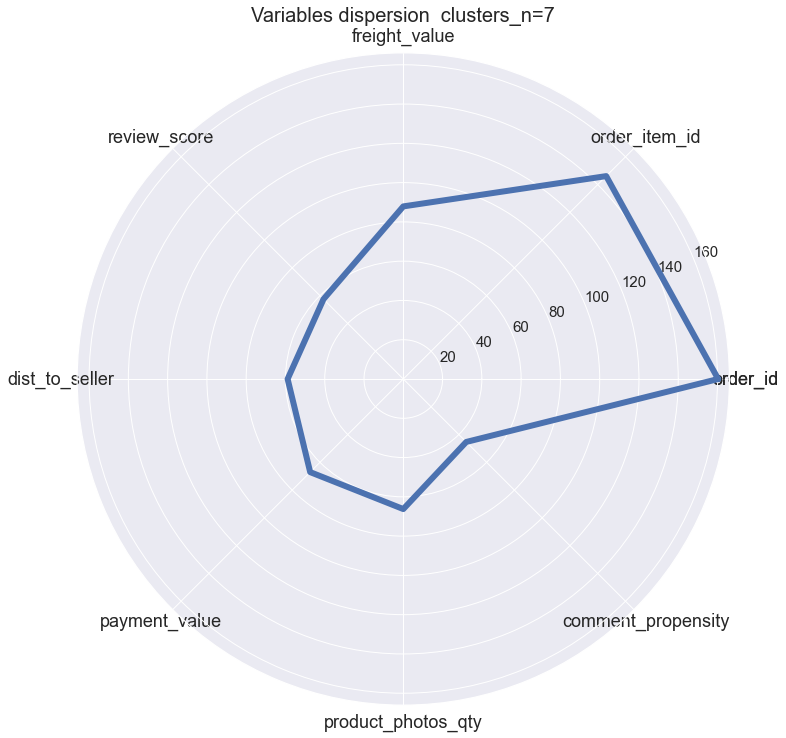

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

# Get columns with dispersion superior than min_dispersion
high_dispersion_columns = list(global_dispersion_vals.index)[:8]
print(high_dispersion_columns)

# Get group names if present
high_dispersion_cat_groups = [
    column for column in high_dispersion_columns if column in cat_groups.keys()]

# Get high_dispersion_columns without group names
high_dispersion_columns = [
    ele for ele in high_dispersion_columns if ele not in high_dispersion_cat_groups]

# Add categories for each group name found in high_dispersion_columns
for key in high_dispersion_cat_groups:
    high_dispersion_columns = high_dispersion_columns+cat_groups[key]

# Create scaled dataframe
dataframe = customers_data[high_dispersion_columns]
dataframe_scaled = preprocessing.StandardScaler().fit_transform(dataframe)
dataframe_scaled = pd.DataFrame(dataframe_scaled, columns=dataframe.columns)

# Create weighted scaled dataframe to avoid overweight categories
dataframe_weighted = dataframe_scaled
for high_disp_cat_group in high_dispersion_cat_groups:
    dataframe_weighted = get_weighted_col(
        dataframe_weighted, cat_groups[key], 1/len(cat_groups[key]))

# Apply KMeans on scaled dataframe
clusterer = KMeans(n_clusters=clusters_n).fit(dataframe_weighted)

# Get dispertion value for each variable
dispersion_vals = get_dispersion(dataframe_weighted, clusterer.labels_)

# Plot dispersion on radarplot
radarplot(dispersion_vals, 'clusters_n='+str(clusters_n))

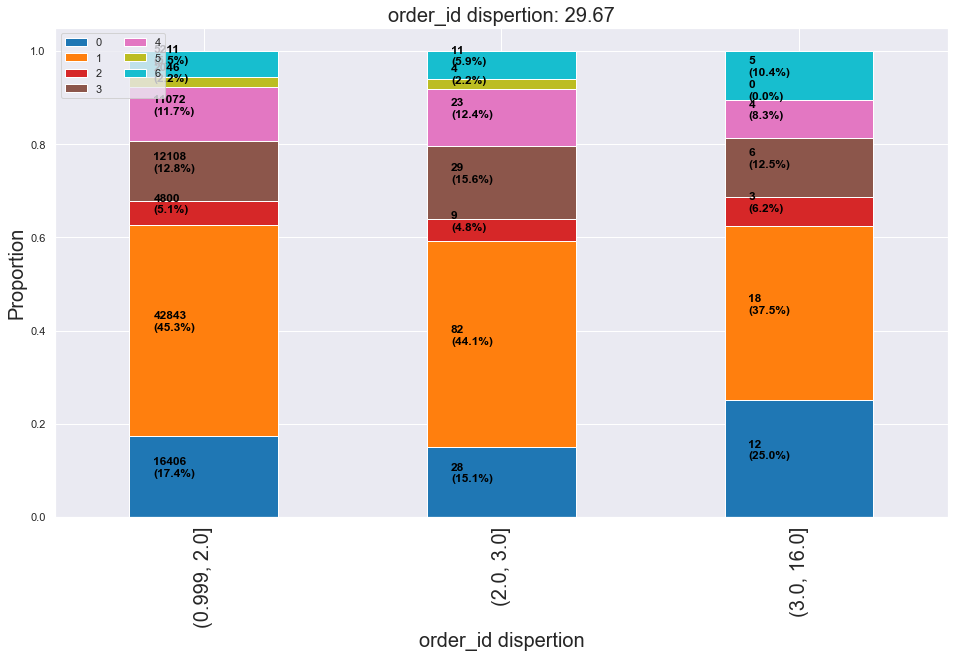

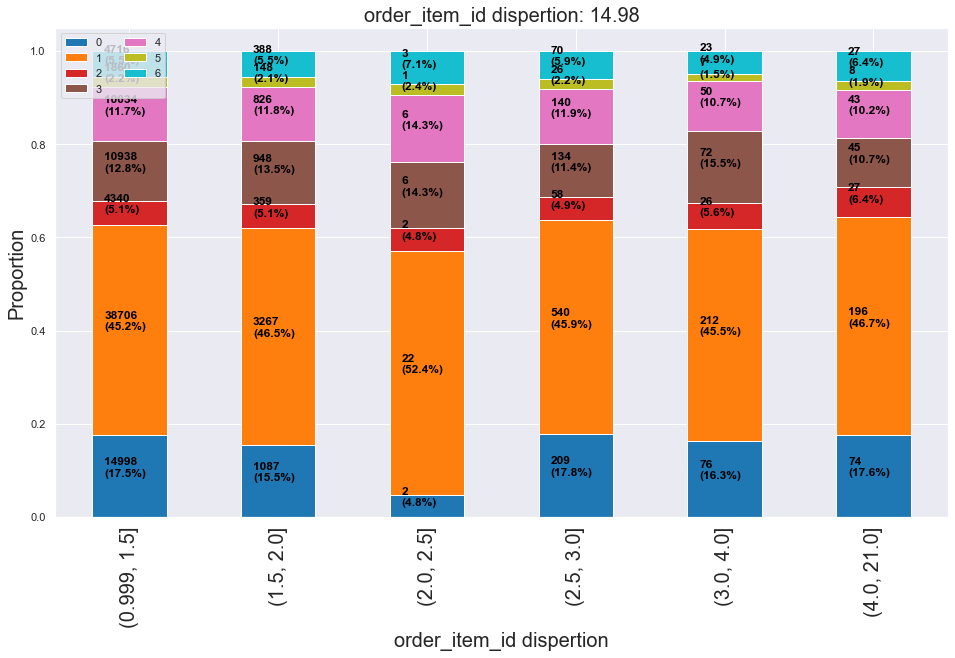

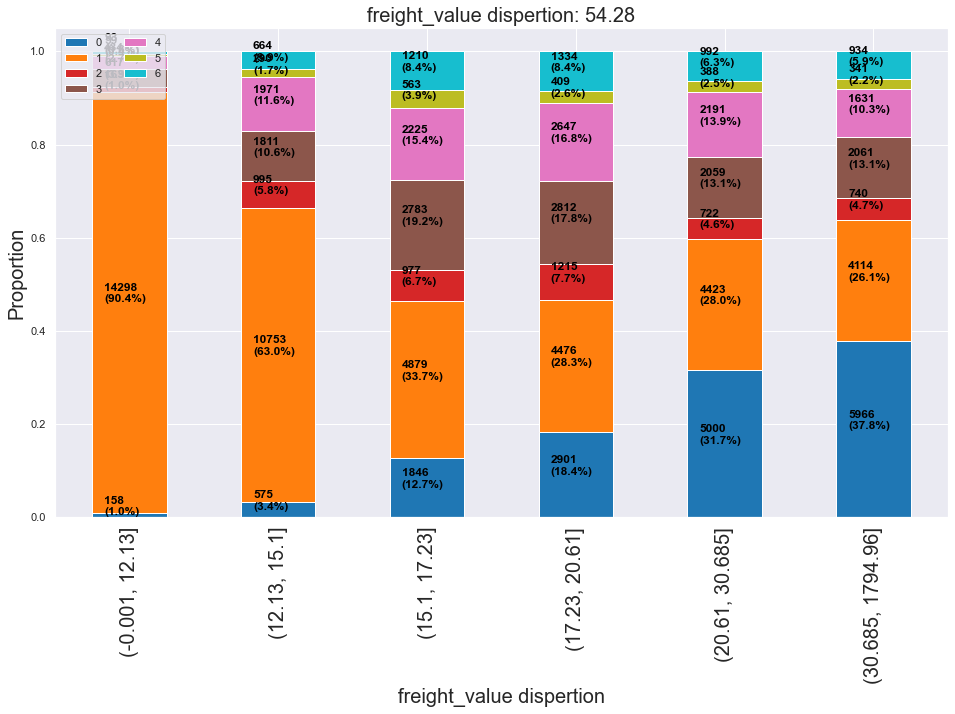

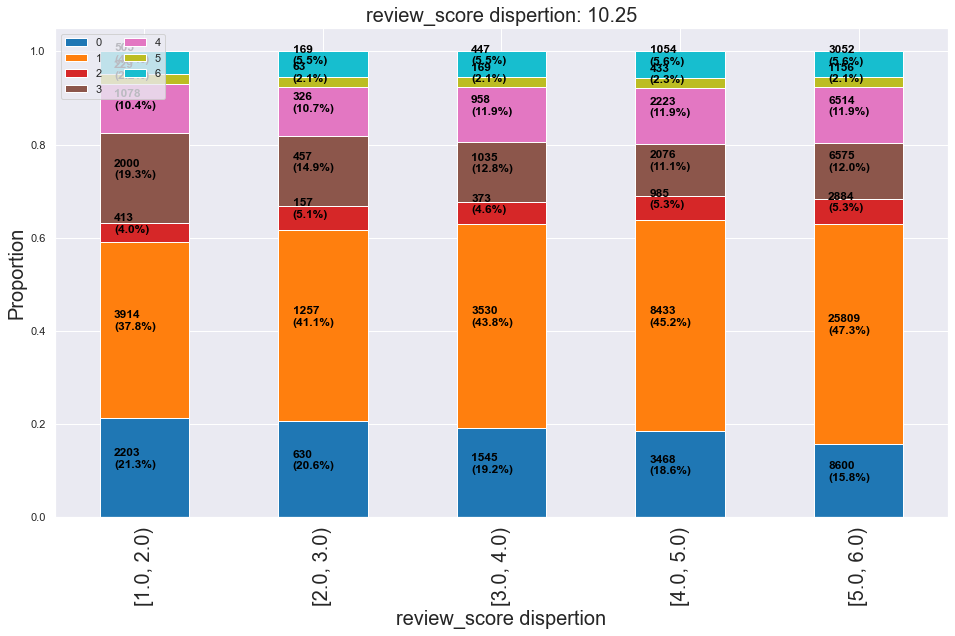

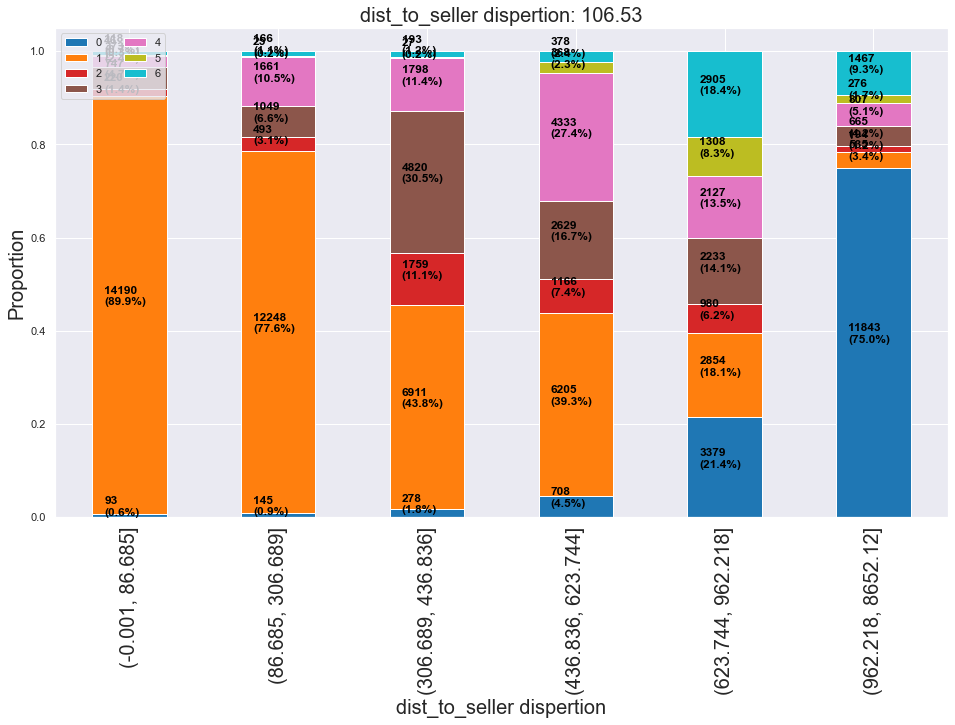

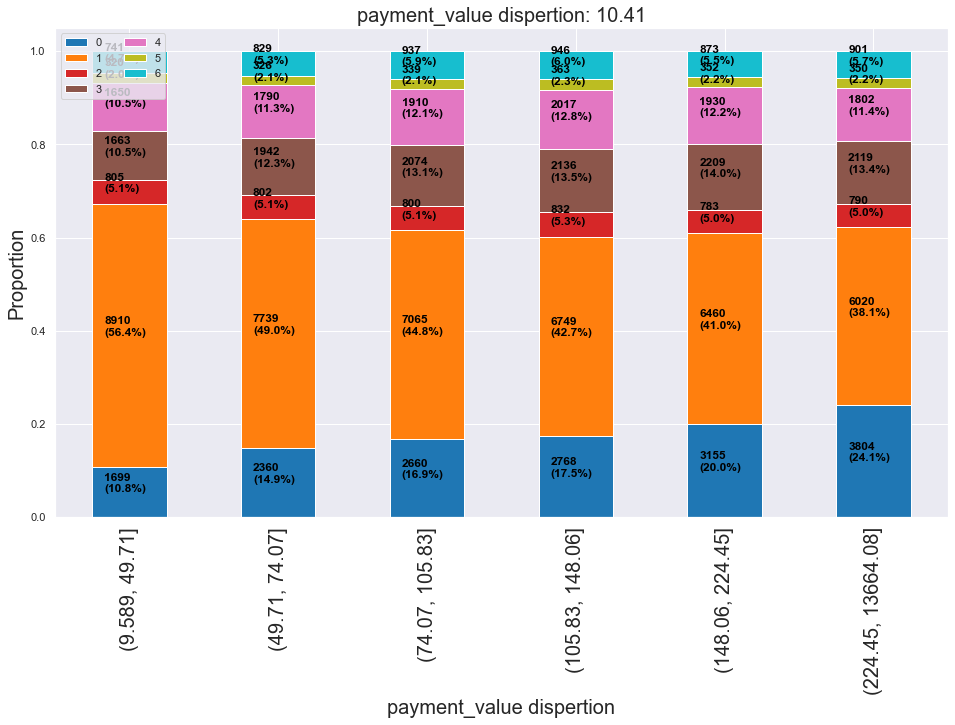

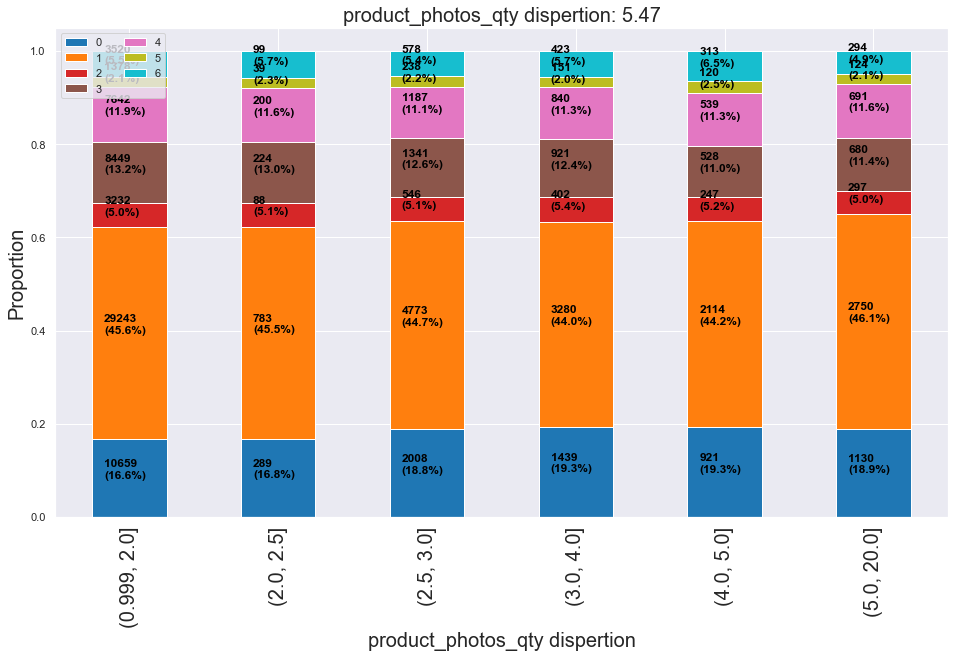

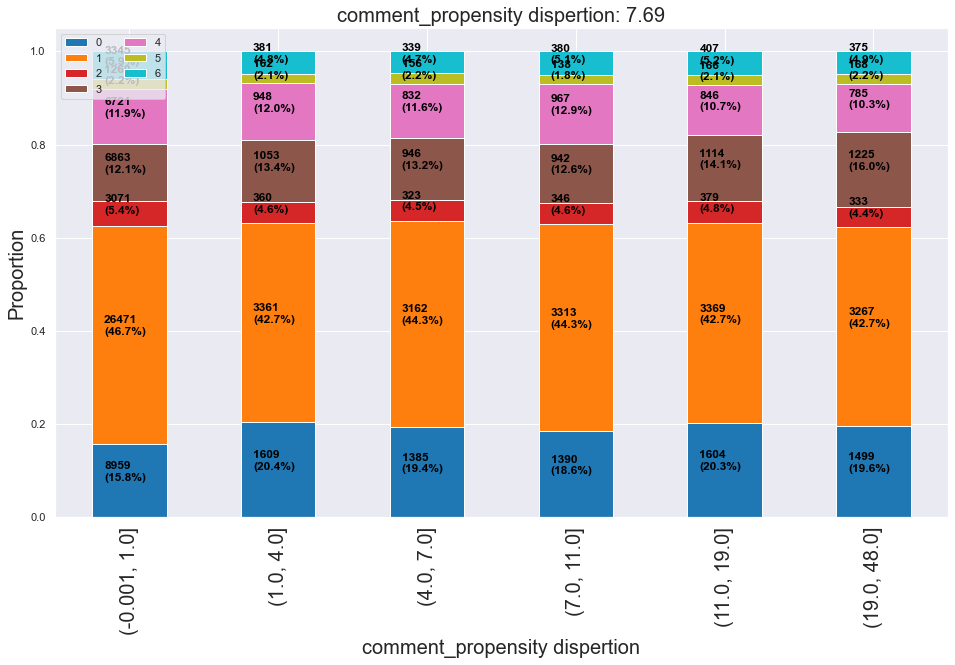

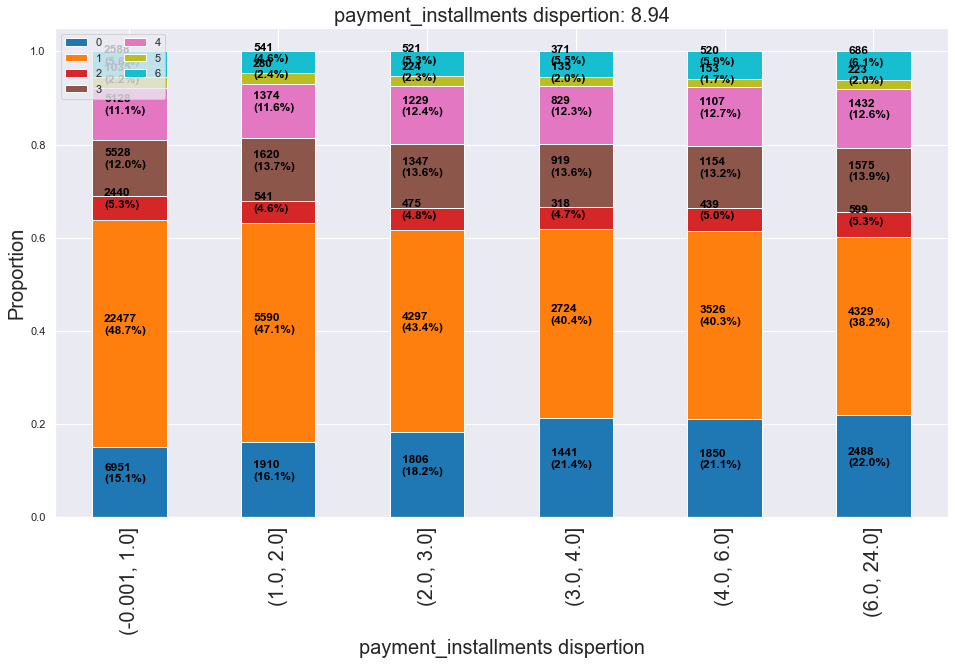

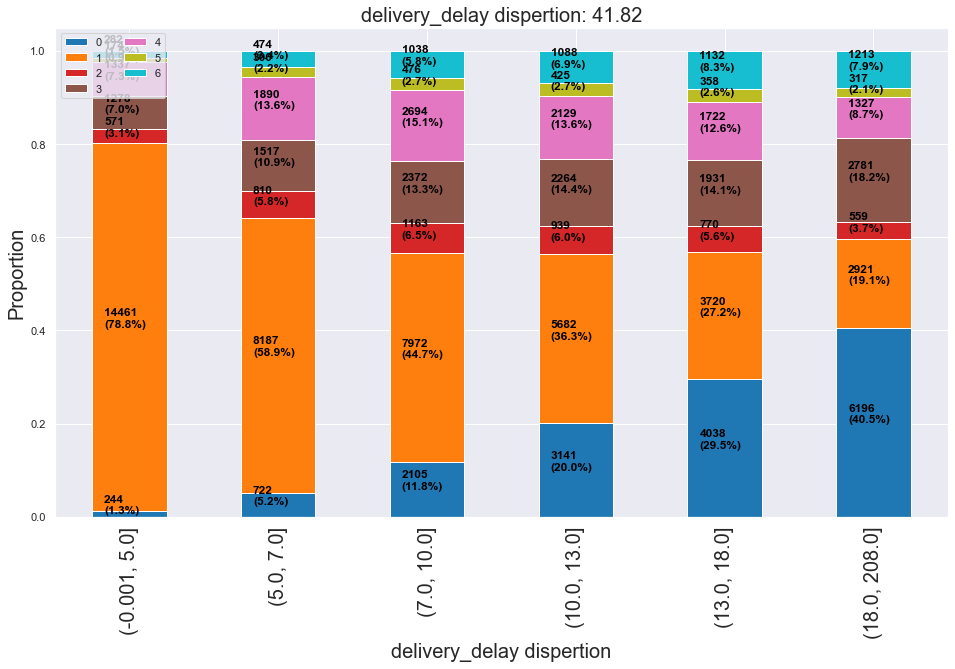

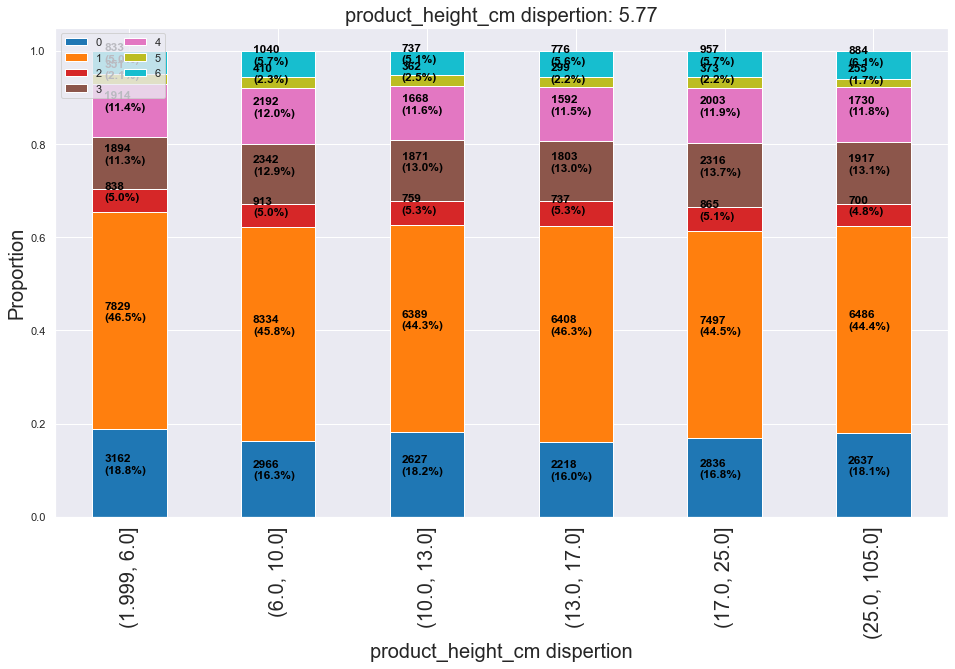

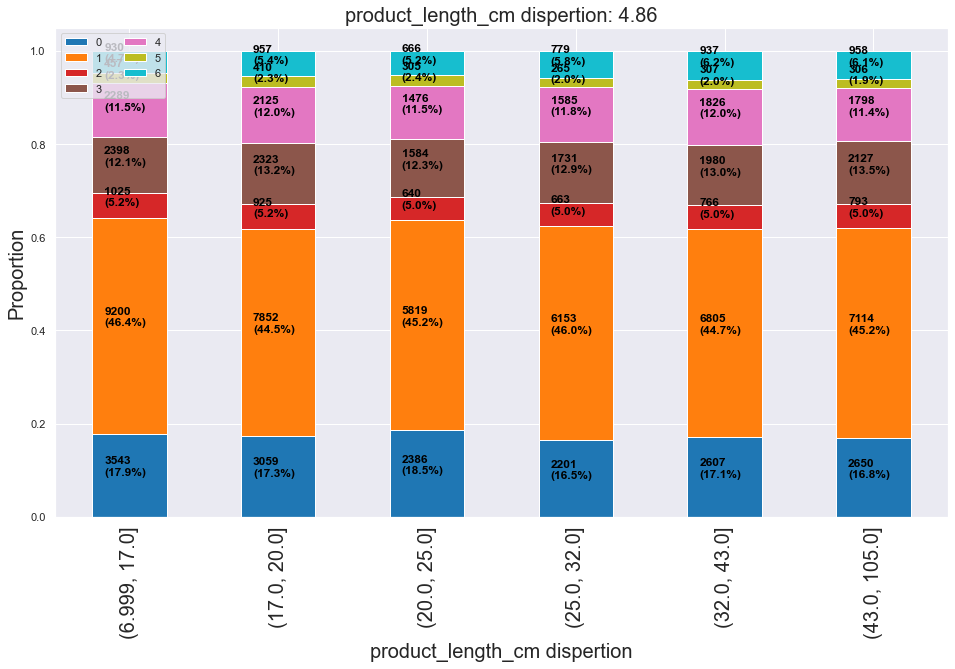

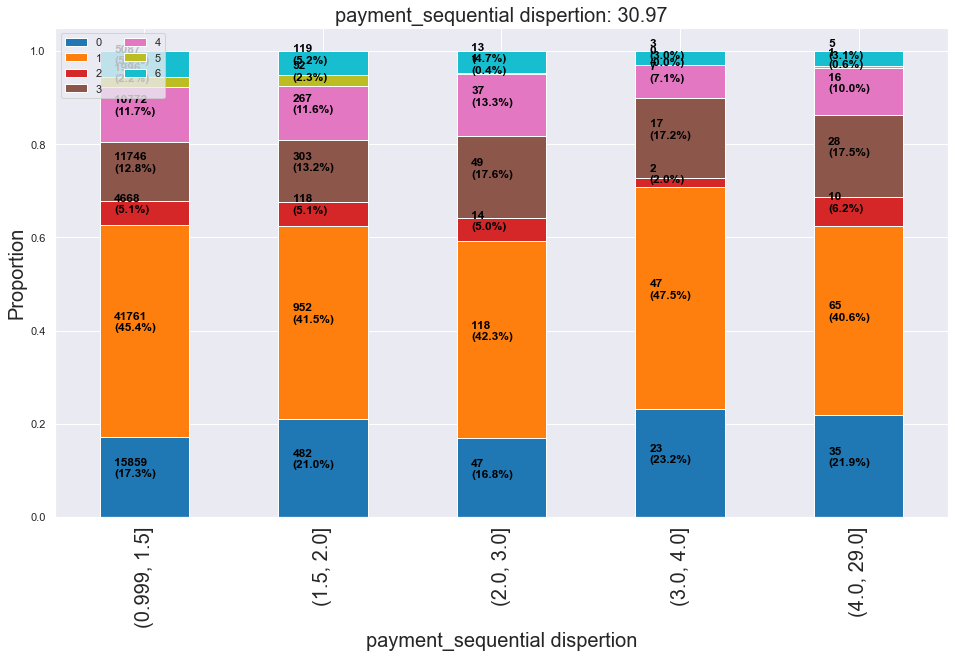

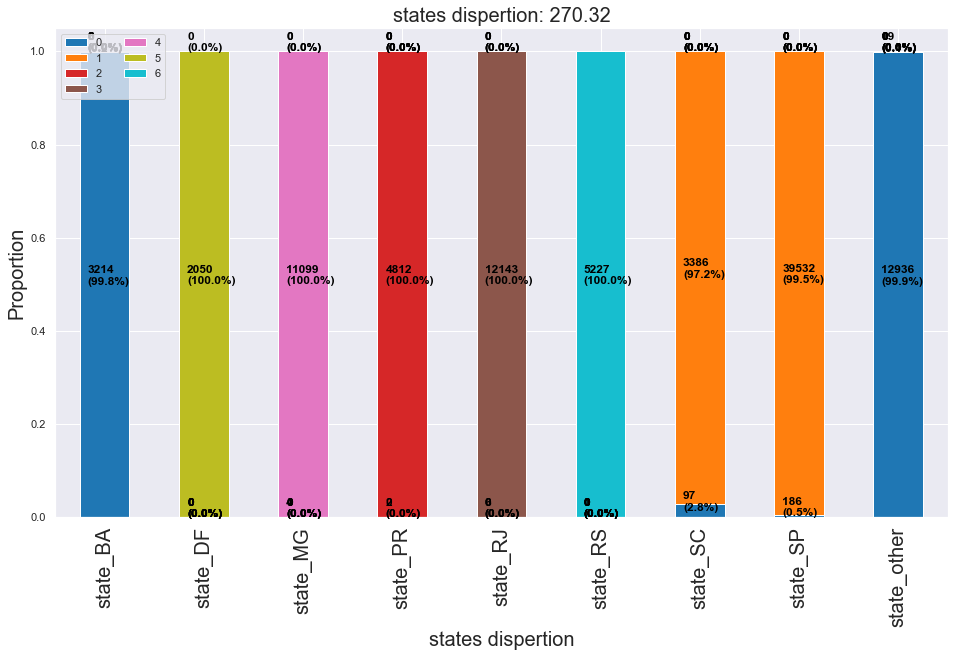

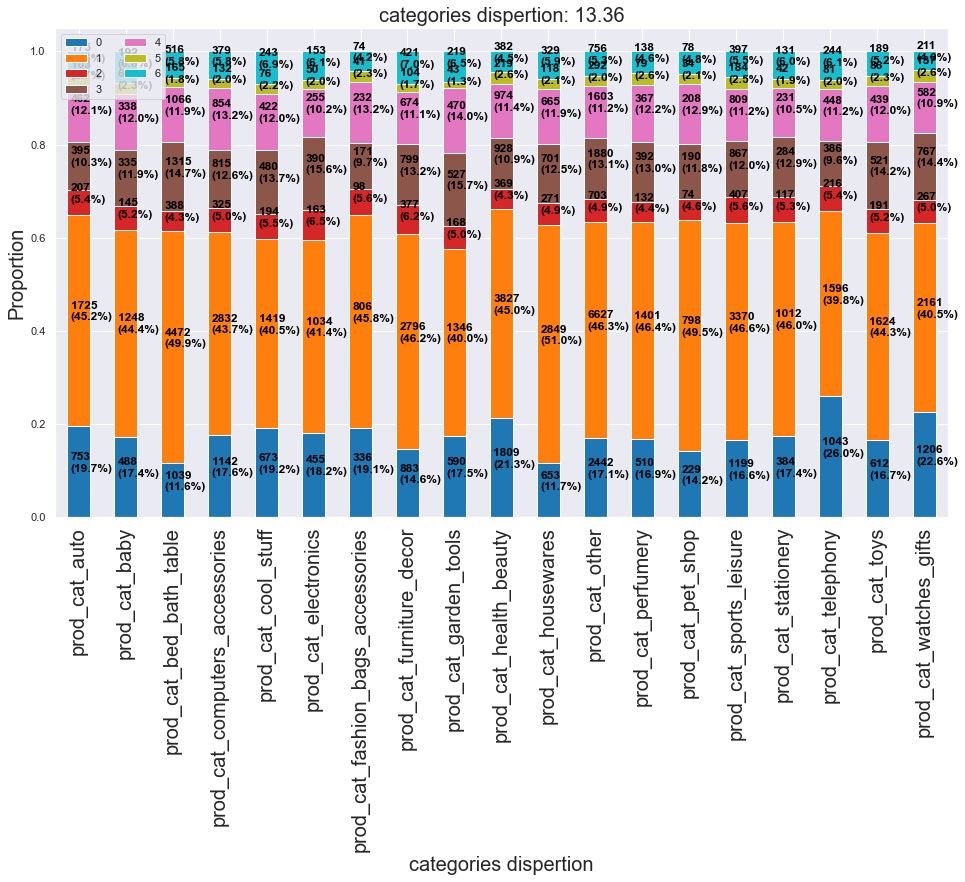

In [17]:
# Visualize repartition
visu_repartition(dataframe, clusterer.labels_)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


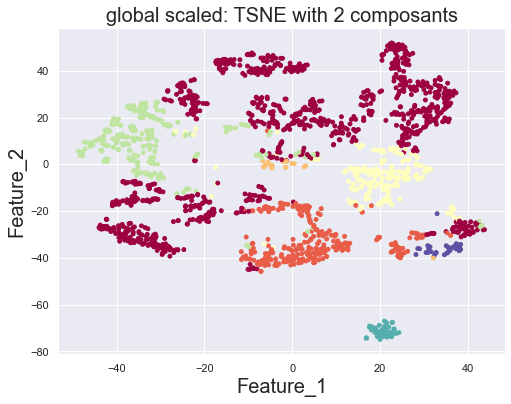

In [21]:
# Visualize clustering result on two features
visu_TSNE('global scaled', dataframe_scaled.loc[::50], clusterer.labels_[::50])